## This notebook presents a very quick overview of the data conversion and analysis that was developed and used during the beamtime in SACLA in May 2016.

Don’t hesitate to contact me if you have questions ([vincent.esposito@psi.ch](mailto:vincent.esposito@psi.ch))

### Main data analysis pipeline

In [1]:
# Assumes a location of the notebook in <dir_path>/sacla/notebooks and photon_tools module is in the same <dir_path>
import os
import sys

dir_path = os.getcwd() + '/../../'

sys.path.append(dir_path + 'sacla')
sys.path.append(dir_path + 'photon_tools')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cPickle as pickle
import functions_SACLA_may2016 as fsacla
import fct_dataAna_may2016 as dataAna

Define test data runs to be processed

In [2]:
runs = [439064, 439065]  # delay
# runs = [439020]  # mirror_tilt
# runs = [439015]  # phi

# runs = np.append(np.arange(439064, 439067, 1), np.arange(439069, 439074, 1))  # bismuth timing
# runs = [439109, 439110, 439111, 439112, 439113]
# runs = [439114, 439115, 439116, 439117, 439118]
# runs = [439121, 439122, 439123, 439124, 439125]

# runs = [439215, 439216, 239217]
# runs = [439189]
# runs = np.arange(439210, 439219, 1) # coarse time scan
# runs = np.arange(439197, 439207, 1) # fine time scan

# flu=-16000:
# runs = [439236, 439237, 439238]                  #time scan 1ns on SL
# runs = [439239, 439244]                          #phi scan SL  1ns
# runs = [439239, 439243]                          #phi scan SL coarse 200ps
# runs = [439245]                                  #phi scan Bragg 1ns
# runs = [439246]                                  #phi scan Bragg 200ps
# runs = [439250]                                  #phi Bragg 200ps
# runs = [439251]                                  #phi Bragg 150ps
# runs = [439252]                                  #phi Bragg 500ps
# runs = [439253]                                  #phi Bragg 50ps
# runs = [439254]                                  #phi Bragg 10ps
# runs = [439255, 439258]                          #phi Bragg -100ps
# runs = [439256]                                  #phi Bragg 1nsps
# runs = [439257]                                  #phi Bragg 500ps

#flu=-21000:
# runs = [439248]                                  #phi scan SL 200ps
# runs = [439249]                                  #phi SL 1ns
# runs = [439259]                                  #time scan SL phi 2260
# runs = [439260, 439261, 439262]                  #time scan SL phi 2250

#flu=-23000:
# runs = [439263, 439264, 439265, 439269]           #time scan SL
# runs = [439266]                                   #phi scan SL 1ns
# runs = [439267]                                   #phi scan SL 200ps
# runs = [439268]                                   #phi scan Bragg 200ps

# runs = [439269]

Choose whether imgAna, loadData and timing tool analysis has to be performed

In [3]:
motor = 'delay'

imgAna = 1
loadData = 1
useTT = 1

fig_num = 132

n = -1

# saveDir = "/home/esposiv/python_scripts2016/analyzed_runs/"
saveDir = "/home/usov_i/SACLA Dec2015/python_scripts2016/analyzed_runs/"


Analyzing run 439064

[INFO] Setting a new dataset, removing stored preprocess functions. To overcome this, use remove_preprocess=False
[INFO] Preprocess subtract_correction added
[INFO] Preprocess set_thr added


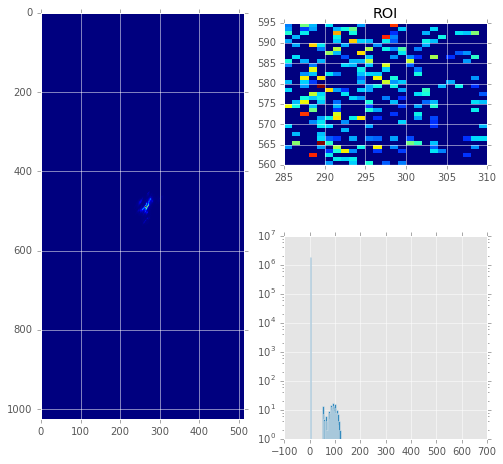


Selection efficiency
          Eff.  Selected  Total
run                            
439064.0   1.0      2070   2070

 I0 filter: 0.897584541063

 TT-data matching: 0.505382131324 of total tags are matching.

Analyzing run 439065

[INFO] Setting a new dataset, removing stored preprocess functions. To overcome this, use remove_preprocess=False
[INFO] Preprocess subtract_correction added
[INFO] Preprocess set_thr added


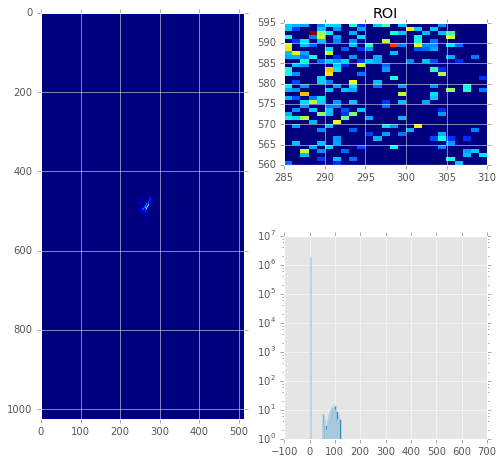


Selection efficiency
          Eff.  Selected  Total
run                            
439065.0   1.0      2070   2070

 I0 filter: 0.905314009662

 TT-data matching: 0.495731056564 of total tags are matching.


In [4]:
if 'df_total' in locals():
    del df_total
    
for run in runs:
    print('\nAnalyzing run ' + str(run) + '\n')
    """ 
    Analyze images and integrate roi and bkgRoi. Can take a lot of time 
    The results are saved in a pickle file in the folder analyzed_runs/imgAna.
    To add prepocess, analysis functions, open the dataAna.imgAna function.
    """
    if imgAna:
        roi = [[560, 595], [285, 310]]  # SL [[xmin xmax], [ymin ymax]]
#         roi = [[420, 470], [190, 230]]  # Bragg Peak [[xmin xmax], [ymin ymax]]        
#         bkgRoi = np.array(roi) #+ np.array([[-40, 40], [-40, 40]])
        bkgRoi = np.array(roi)
        results = dataAna.imgAna(str(run), roi, bkgRoi, n=n)
    
    """ 
    Load the data from the hdf5 file and append the roi and bkgRoi intensities calculated above
    The results are saved in a pickle file in the folder analyzed_runs.
    To change daq_labels, filters, etc, open the dataAna.loadData function.
    """
    if loadData:
        df = dataAna.loadData(str(run), useTT=useTT)
    
    """ Appends all dataframes together in a big dataframe df_total """
    file = saveDir + str(run) + "_may2016" + ".p"
    if 'df_total' in locals():
        df_total = df_total.append(pickle.load(open(file, "rb")))
    else:
        df_total = pickle.load(open(file, "rb"))

Filter intensity values that are out of range

In [5]:
# df_total = df_total[df_total.intensity < 160000]

Rebinning according to the timing tool corrected values

In [6]:
if useTT:
#     bin_edges = np.linspace(-550000, 1100000, 150) # [fs]
    bin_edges = np.arange(-8000, 20000, 40)  # [fs]
    df_binned = fsacla.bin_tt(df_total[df_total.laser_status == 1], bin_edges, calibration=-2.8)

No laser OFF shots


Average without timing tool

In [7]:
df_ave = fsacla.bin_motor(df_total, motor=motor)

No laser OFF shots


Ploting

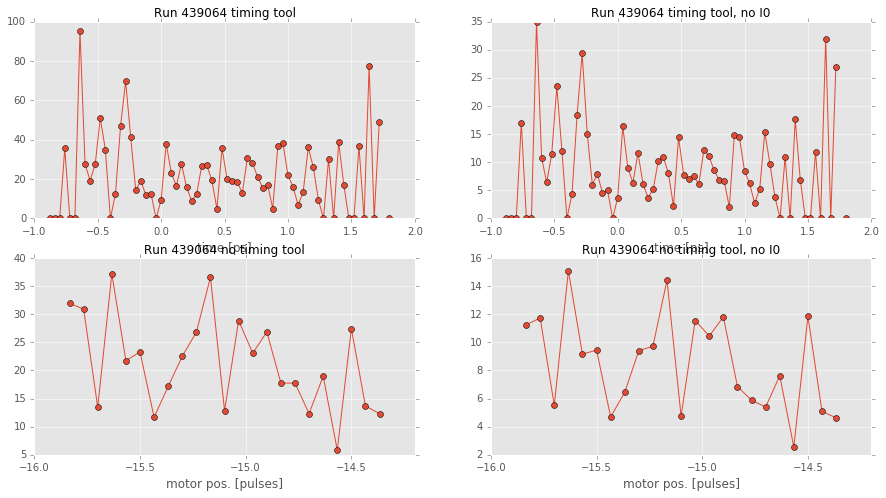

In [8]:
plt.figure(fig_num, figsize=(15, 12))
if useTT:
    time = df_binned.time
#     on =  (df_binned.intensity_lon-df_binned.bkg_lon)/df_binned.I0_lon
#     on_raw = df_binned.intensity_lon-df_binned.bkg_lon
    on = df_binned.intensity_lon/df_binned.I0_lon
    on_raw = df_binned.intensity_lon
    plt.subplot(3, 2, 1)
    plt.title('Run ' + str(runs[0]) + ' timing tool', fontsize=12)
    plt.plot((time+700)/1000, on, '-o', label='laser on')
    plt.xlabel('time [ps]')
    plt.subplot(3, 2, 2)
    plt.title('Run ' + str(runs[0]) + ' timing tool, no I0', fontsize=12)
    plt.plot((time+700)/1000, on_raw, '-o', label='laser on')
    plt.xlabel('time [ps]')

if motor is 'delay':
    motor = df_ave[motor]*6.66667/1000
else:
    motor = df_ave[motor]

if 'intensity_lon' in df_ave:
#     on =  (df_ave.intensity_lon-df_ave.bkg_lon)/df_ave.I0_lon
#     on_raw =  (df_ave.intensity_lon-df_ave.bkg_lon)
    on = df_ave.intensity_lon/df_ave.I0_lon
    on_raw = df_ave.intensity_lon

    plt.subplot(3, 2, 3)
    plt.title('Run ' + str(runs[0]) + ' no timing tool', fontsize=12)
    plt.plot(motor, on, '-o', label='laser on')
    plt.xlabel('motor pos. [pulses]')
    plt.subplot(3, 2, 4)
    plt.title('Run ' + str(runs[0]) + ' no timing tool, no I0', fontsize=12)
    plt.plot(motor, on_raw, '-o', label='laser on')
    plt.xlabel('motor pos. [pulses]')

if 'intensity_loff' in df_ave:
#     off =  (df_ave.intensity_loff-df_ave.bkg_loff)/df_ave.I0_loff
#     off_raw =  df_ave.intensity_loff-df_ave.bkg_loff
    off = df_ave.intensity_loff/df_ave.I0_loff
    off_raw = df_ave.intensity_loff

    plt.subplot(3, 2, 3)
    plt.plot(motor, off, '-o', label='laser off')
    plt.xlabel('motor pos. [pulses]')
    plt.legend(loc='lower left')
    plt.subplot(3, 2, 4)
    plt.plot(motor, off_raw, '-o', label='laser off')
    plt.legend(loc='lower left')
    plt.xlabel('motor pos. [pulses]')

    if 'intensity_lon' in df_ave:
        plt.subplot(3, 2, 5)
        plt.title('Run ' + str(runs[0]) + ' difference', fontsize=12)
        plt.plot(motor, (on-off), '-o', label='diff')
        plt.xlabel('motor pos. [pulses]')
        plt.legend(loc='lower left')
        plt.subplot(3, 2, 6)
        plt.title('Run ' + str(runs[0]) + ' difference, no I0', fontsize=12)
        plt.plot(motor, on_raw-off_raw, '-o',label='diff')
        plt.legend(loc='lower left')
        plt.xlabel('motor pos. [pulses]')